## （一）线性问题与非线性问题
### 1.实例：线性logistic回归处理二分类问题
- 用线性单分逻辑回归分析肿瘤是良性的还是恶性的，样本特征包括病人的年龄和肿瘤大小，标签是良性和恶性

#### （1）生成样本集
- 二维数组“病人的年纪、肿瘤的大小”
- generate 为生成模拟样本的函数，按照指定均值和方差生成固定样本

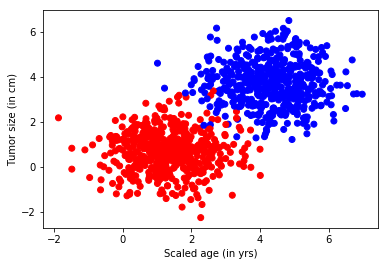

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
%matplotlib inline

#模拟数据点   
def generate(sample_size, mean, cov, diff,regression):   
    num_classes = 2 #len(diff)
    samples_per_class = int(sample_size/2)

    X0 = np.random.multivariate_normal(mean, cov, samples_per_class)
    Y0 = np.zeros(samples_per_class)
    
    for ci, d in enumerate(diff):
        X1 = np.random.multivariate_normal(mean+d, cov, samples_per_class)
        Y1 = (ci+1)*np.ones(samples_per_class)
    
        X0 = np.concatenate((X0,X1))
        Y0 = np.concatenate((Y0,Y1))
        
    if regression==False: #one-hot  0 into the vector "1 0
        class_ind = [Y==class_number for class_number in range(num_classes)]
        Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    X, Y = shuffle(X0, Y0)
    
    return X,Y    

input_dim = 2                    
np.random.seed(10)
num_classes =2
mean = np.random.randn(num_classes)
cov = np.eye(num_classes) 
X, Y = generate(1000, mean, cov, [3.0],True)
colors = ['r' if l == 0 else 'b' for l in Y[:]]
plt.scatter(X[:,0], X[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()
lab_dim = 1

#### (2)构建网络结构——定义输入输出占位符，w,b的权重
- 使用sigmoid激活函数
- loss使用交叉熵，里面加入一个平方差函数，用来评估模型错误率
- 使用AdamOptimizer优化器

In [13]:
input_features = tf.placeholder(tf.float32,[None,input_dim])
input_labels = tf.placeholder(tf.float32,[None,lab_dim])
# 定义学习参数
W = tf.Variable(tf.random_normal([input_dim,lab_dim],name='weight'))
b = tf.Variable(tf.zeros([lab_dim]),name='bias')

output = tf.nn.sigmoid(tf.matmul(input_features,W) + b)
cross_entropy = -(input_labels * tf.log(output) + (1 - input_labels) * tf.log(1 - output))
ser = tf.square(input_labels - output)
loss = tf.reduce_mean(cross_entropy)
err = tf.reduce_mean(ser)
optimizer = tf.train.AdamOptimizer(0.04)
train = optimizer.minimize(loss)

#### (3)设置参数进行训练和可视化
- 整个数据集迭代50次，每次的minibatch选25条
- 可视化中模型生成的结果是：z = x1w1 + x2w2 + b,为了刻画在x，y坐标中的直线，令公式中的z为0，转化为如下直线方程：
    - y = -x*(w1/w2) - b/w2

Epoch: 0001 cost= 0.545349956 err= 0.0005056727010011674
Epoch: 0002 cost= 0.245186925 err= 0.00023011412262916565
Epoch: 0003 cost= 0.156825393 err= 9.725593194365502e-05
Epoch: 0004 cost= 0.124442369 err= 6.0889308974146845e-05
Epoch: 0005 cost= 0.106172055 err= 4.78150712326169e-05
Epoch: 0006 cost= 0.093689792 err= 4.0866414476186037e-05
Epoch: 0007 cost= 0.084405191 err= 3.6402720231562854e-05
Epoch: 0008 cost= 0.077159159 err= 3.325663539581001e-05
Epoch: 0009 cost= 0.071321771 err= 3.091837300918997e-05
Epoch: 0010 cost= 0.066507824 err= 2.911830764263868e-05
Epoch: 0011 cost= 0.062463637 err= 2.769609661772847e-05
Epoch: 0012 cost= 0.059013672 err= 2.6549129472114144e-05
Epoch: 0013 cost= 0.056032162 err= 2.5608385228551925e-05
Epoch: 0014 cost= 0.053426661 err= 2.4825673205778003e-05
Epoch: 0015 cost= 0.051127687 err= 2.4166430570185184e-05
Epoch: 0016 cost= 0.049081814 err= 2.360523807350546e-05
Epoch: 0017 cost= 0.047247592 err= 2.3123023028019814e-05
Epoch: 0018 cost= 0.045

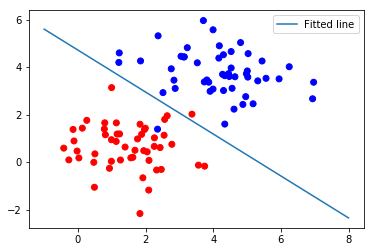

In [14]:
maxEpochs = 50
minibatchSize = 25
# 启动Session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # 向模型输入数据
    for epoch in range(maxEpochs):
        sumerr = 0
        for i in range(np.int(len(Y)/minibatchSize)):
            x1 = X[i*minibatchSize:(i+1)*minibatchSize]
            y1 = np.reshape(Y[i*minibatchSize:(i+1)*minibatchSize],[-1,1])
            _,lossval,outputval,errval = sess.run([train,loss,output,err],feed_dict={input_features:x1,input_labels:y1})
            sumerr = sumerr + errval
        print('Epoch:','%04d'%(epoch+1),'cost=','{:.9f}'.format(lossval),'err=',sumerr/np.int(len(Y))/minibatchSize)
    train_X,train_Y = generate(100,mean,cov,[3.0],True)
    colors = ['r' if l == 0 else 'b' for l in train_Y[:]]
    plt.scatter(train_X[:,0],train_X[:,1],c=colors)
    x = np.linspace(-1,8,200)
    y = -x * (sess.run(W)[0]/sess.run(W)[1]) - sess.run(b)/sess.run(W)[1]
    plt.plot(x,y,label = 'Fitted line')
    plt.legend()
    plt.show()

#### 结论：上图所示情况表示数据是线性可分的

### 2.实例：线性logistic回归处理多分类问题
- 通过softmax分类的方法计算神经网络输出

#### （1）生成样本集

E:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


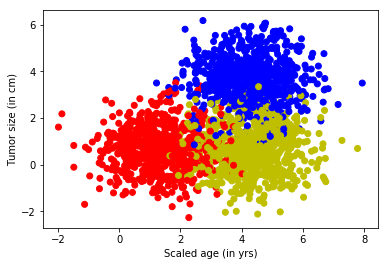

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from matplotlib.colors import colorConverter, ListedColormap 
%matplotlib inline
    
# 对于上面的fit可以这么扩展变成动态的
from sklearn.preprocessing import OneHotEncoder
def onehot(y,start,end):
    ohe = OneHotEncoder()
    a = np.linspace(start,end-1,end-start)
    b =np.reshape(a,[-1,1]).astype(np.int32)
    ohe.fit(b)
    c=ohe.transform(y).toarray()  
    return c     
#
    
def generate(sample_size, num_classes, diff,regression=False):
    np.random.seed(10)
    mean = np.random.randn(2)
    cov = np.eye(2)  
    
    #len(diff)
    samples_per_class = int(sample_size/num_classes)

    X0 = np.random.multivariate_normal(mean, cov, samples_per_class)
    Y0 = np.zeros(samples_per_class)
    
    for ci, d in enumerate(diff):
        X1 = np.random.multivariate_normal(mean+d, cov, samples_per_class)
        Y1 = (ci+1)*np.ones(samples_per_class)
    
        X0 = np.concatenate((X0,X1))
        Y0 = np.concatenate((Y0,Y1))
        #print(X0, Y0)
    
  
    if regression==False: #one-hot  0 into the vector "1 0
        Y0 = np.reshape(Y0,[-1,1])        
        #print(Y0.astype(np.int32))
        Y0 = onehot(Y0.astype(np.int32),0,num_classes)
        #print(Y0)
    X, Y = shuffle(X0, Y0)
    #print(X, Y)
    return X,Y    

 
# Ensure we always get the same amount of randomness
np.random.seed(10)

input_dim = 2
num_classes =3 
X, Y = generate(2000,num_classes,  [[3.0],[3.0,0]],False)
aa = [np.argmax(l) for l in Y]
colors =['r' if l == 0 else 'b' if l==1 else 'y' for l in aa[:]]

plt.scatter(X[:,0], X[:,1], c=colors)
plt.xlabel("Scaled age (in yrs)")
plt.ylabel("Tumor size (in cm)")
plt.show()

lab_dim = num_classes

#### （2）构建网络结构
- 使用softmax分类，loss仍然使用交叉熵，错误率的评估换成one-hot编码中不相同的个数，优化器使用Adam

In [16]:
lab_dim = num_classes
# 定义占位符
input_features = tf.placeholder(tf.float32,[None,input_dim])
input_lables = tf.placeholder(tf.float32,[None,lab_dim])
# 定义学习参数
W = tf.Variable(tf.random_normal([input_dim,lab_dim]),name='weight')
b = tf.Variable(tf.zeros([lab_dim],name='bias'))
output = tf.matmul(input_features,W) + b

z = tf.nn.softmax(output)
a1 = tf.argmax(tf.nn.softmax(output),axis=1)
b1 = tf.argmax(input_lables,axis=1)
err = tf.count_nonzero(a1-b1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=input_lables,logits=output)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(0.04)
train = optimizer.minimize(loss)

#### (3)设置参数进行训练
- 数据集迭代50次，每次minibatch取25条

Epoch: 0001 cost= 1.309700012 err= 1.1211211211211213e-05
Epoch: 0001 cost= 0.961092293 err= 2.002002002002002e-05
Epoch: 0001 cost= 0.995440722 err= 2.9629629629629627e-05
Epoch: 0001 cost= 0.850565732 err= 3.7637637637637636e-05
Epoch: 0001 cost= 0.855918050 err= 4.484484484484484e-05
Epoch: 0001 cost= 1.016691327 err= 5.525525525525525e-05
Epoch: 0001 cost= 0.455547094 err= 6.0860860860860864e-05
Epoch: 0001 cost= 0.520367503 err= 6.726726726726727e-05
Epoch: 0001 cost= 0.621867418 err= 7.047047047047046e-05
Epoch: 0001 cost= 0.748378932 err= 7.687687687687687e-05
Epoch: 0001 cost= 0.506513774 err= 8.088088088088088e-05
Epoch: 0001 cost= 0.764507055 err= 8.80880880880881e-05
Epoch: 0001 cost= 0.893141866 err= 9.44944944944945e-05
Epoch: 0001 cost= 0.650064230 err= 9.929929929929932e-05
Epoch: 0001 cost= 0.602383256 err= 0.00010570570570570572
Epoch: 0001 cost= 0.552126408 err= 0.00010970970970970973
Epoch: 0001 cost= 0.854468584 err= 0.00011771771771771775
Epoch: 0001 cost= 0.575202

Epoch: 0003 cost= 0.190798908 err= 2.162162162162162e-05
Epoch: 0003 cost= 0.251106948 err= 2.3223223223223225e-05
Epoch: 0003 cost= 0.310436726 err= 2.482482482482483e-05
Epoch: 0003 cost= 0.221365929 err= 2.642642642642643e-05
Epoch: 0003 cost= 0.496945530 err= 3.123123123123124e-05
Epoch: 0003 cost= 0.418391138 err= 3.3633633633633635e-05
Epoch: 0003 cost= 0.282716453 err= 3.603603603603604e-05
Epoch: 0003 cost= 0.263807416 err= 3.603603603603604e-05
Epoch: 0003 cost= 0.273768514 err= 3.763763763763764e-05
Epoch: 0003 cost= 0.422405392 err= 4.164164164164166e-05
Epoch: 0003 cost= 0.132675394 err= 4.164164164164166e-05
Epoch: 0003 cost= 0.160812229 err= 4.164164164164166e-05
Epoch: 0003 cost= 0.215726390 err= 4.244244244244245e-05
Epoch: 0003 cost= 0.402547479 err= 4.484484484484486e-05
Epoch: 0003 cost= 0.320564419 err= 4.724724724724726e-05
Epoch: 0003 cost= 0.500695586 err= 5.285285285285286e-05
Epoch: 0003 cost= 0.268330365 err= 5.445445445445446e-05
Epoch: 0003 cost= 0.159814820

Epoch: 0005 cost= 0.226760164 err= 4.804804804804804e-06
Epoch: 0005 cost= 0.300204962 err= 6.406406406406406e-06
Epoch: 0005 cost= 0.345028043 err= 8.808808808808808e-06
Epoch: 0005 cost= 0.239963382 err= 1.2812812812812813e-05
Epoch: 0005 cost= 0.610478163 err= 1.841841841841842e-05
Epoch: 0005 cost= 0.140702233 err= 1.841841841841842e-05
Epoch: 0005 cost= 0.150259718 err= 1.921921921921922e-05
Epoch: 0005 cost= 0.211751387 err= 2.0820820820820822e-05
Epoch: 0005 cost= 0.252526671 err= 2.162162162162162e-05
Epoch: 0005 cost= 0.213350385 err= 2.3223223223223225e-05
Epoch: 0005 cost= 0.484641463 err= 2.802802802802803e-05
Epoch: 0005 cost= 0.376001865 err= 3.0430430430430432e-05
Epoch: 0005 cost= 0.256676763 err= 3.2832832832832836e-05
Epoch: 0005 cost= 0.211294860 err= 3.2832832832832836e-05
Epoch: 0005 cost= 0.247473791 err= 3.443443443443444e-05
Epoch: 0005 cost= 0.381856471 err= 3.843843843843844e-05
Epoch: 0005 cost= 0.093173429 err= 3.843843843843844e-05
Epoch: 0005 cost= 0.12316

Epoch: 0007 cost= 0.400588065 err= 0.00013853853853853861
Epoch: 0007 cost= 0.227369845 err= 0.00014014014014014024
Epoch: 0007 cost= 0.276267648 err= 0.00014334334334334343
Epoch: 0007 cost= 0.249342769 err= 0.00014494494494494503
Epoch: 0007 cost= 0.218656495 err= 0.00014654654654654663
Epoch: 0007 cost= 0.350752264 err= 0.00014814814814814823
Epoch: 0008 cost= 0.259298861 err= 1.6016016016016016e-06
Epoch: 0008 cost= 0.199842274 err= 3.203203203203203e-06
Epoch: 0008 cost= 0.262139410 err= 4.804804804804804e-06
Epoch: 0008 cost= 0.336113155 err= 7.207207207207207e-06
Epoch: 0008 cost= 0.231385782 err= 9.609609609609609e-06
Epoch: 0008 cost= 0.639430523 err= 1.5215215215215216e-05
Epoch: 0008 cost= 0.121679135 err= 1.5215215215215216e-05
Epoch: 0008 cost= 0.133628011 err= 1.601601601601602e-05
Epoch: 0008 cost= 0.190693811 err= 1.6816816816816817e-05
Epoch: 0008 cost= 0.221464977 err= 1.6816816816816817e-05
Epoch: 0008 cost= 0.212574705 err= 1.841841841841842e-05
Epoch: 0008 cost= 0.

Epoch: 0011 cost= 0.174402848 err= 6.326326326326327e-05
Epoch: 0011 cost= 0.232876688 err= 6.486486486486489e-05
Epoch: 0011 cost= 0.440217584 err= 7.04704704704705e-05
Epoch: 0011 cost= 0.150897205 err= 7.127127127127129e-05
Epoch: 0011 cost= 0.441063225 err= 7.52752752752753e-05
Epoch: 0011 cost= 0.060537487 err= 7.607607607607611e-05
Epoch: 0011 cost= 0.277502060 err= 7.767767767767771e-05
Epoch: 0011 cost= 0.189309984 err= 7.927927927927932e-05
Epoch: 0011 cost= 0.167178974 err= 8.08808808808809e-05
Epoch: 0011 cost= 0.354250133 err= 8.328328328328333e-05
Epoch: 0011 cost= 0.155275375 err= 8.488488488488491e-05
Epoch: 0011 cost= 0.123463467 err= 8.568568568568572e-05
Epoch: 0011 cost= 0.285490036 err= 8.728728728728734e-05
Epoch: 0011 cost= 0.235420525 err= 8.968968968968973e-05
Epoch: 0011 cost= 0.160731852 err= 9.049049049049053e-05
Epoch: 0011 cost= 0.196024895 err= 9.129129129129134e-05
Epoch: 0011 cost= 0.141994014 err= 9.129129129129134e-05
Epoch: 0011 cost= 0.088317901 err=

Epoch: 0014 cost= 0.091884196 err= 3.5235235235235246e-05
Epoch: 0014 cost= 0.155498654 err= 3.683683683683685e-05
Epoch: 0014 cost= 0.351460606 err= 3.923923923923925e-05
Epoch: 0014 cost= 0.315019727 err= 4.164164164164166e-05
Epoch: 0014 cost= 0.469085425 err= 4.644644644644645e-05
Epoch: 0014 cost= 0.197696820 err= 4.884884884884886e-05
Epoch: 0014 cost= 0.125777587 err= 4.964964964964966e-05
Epoch: 0014 cost= 0.346427143 err= 5.205205205205206e-05
Epoch: 0014 cost= 0.071201503 err= 5.205205205205206e-05
Epoch: 0014 cost= 0.193572849 err= 5.365365365365367e-05
Epoch: 0014 cost= 0.284741074 err= 5.605605605605607e-05
Epoch: 0014 cost= 0.292537093 err= 5.845845845845848e-05
Epoch: 0014 cost= 0.211335182 err= 6.006006006006008e-05
Epoch: 0014 cost= 0.134986684 err= 6.086086086086088e-05
Epoch: 0014 cost= 0.253550649 err= 6.166166166166168e-05
Epoch: 0014 cost= 0.112120740 err= 6.166166166166168e-05
Epoch: 0014 cost= 0.169898897 err= 6.246246246246249e-05
Epoch: 0014 cost= 0.232928634 

Epoch: 0017 cost= 0.272217512 err= 8.248248248248252e-05
Epoch: 0017 cost= 0.225134283 err= 8.488488488488491e-05
Epoch: 0017 cost= 0.161117405 err= 8.568568568568572e-05
Epoch: 0017 cost= 0.189516753 err= 8.648648648648652e-05
Epoch: 0017 cost= 0.129434764 err= 8.648648648648652e-05
Epoch: 0017 cost= 0.085241042 err= 8.728728728728734e-05
Epoch: 0017 cost= 0.169635549 err= 8.888888888888895e-05
Epoch: 0017 cost= 0.252625793 err= 9.129129129129134e-05
Epoch: 0017 cost= 0.131510034 err= 9.209209209209214e-05
Epoch: 0017 cost= 0.139109999 err= 9.369369369369374e-05
Epoch: 0017 cost= 0.111806653 err= 9.369369369369374e-05
Epoch: 0017 cost= 0.271999687 err= 9.609609609609614e-05
Epoch: 0017 cost= 0.373762041 err= 9.929929929929936e-05
Epoch: 0017 cost= 0.296924770 err= 0.00010250250250250256
Epoch: 0017 cost= 0.185399279 err= 0.00010410410410410415
Epoch: 0017 cost= 0.194113731 err= 0.00010730730730730738
Epoch: 0017 cost= 0.303605378 err= 0.00011131131131131138
Epoch: 0017 cost= 0.3126985

Epoch: 0020 cost= 0.126265302 err= 0.0001217217217217218
Epoch: 0020 cost= 0.193365216 err= 0.00012252252252252258
Epoch: 0020 cost= 0.477894276 err= 0.0001257257257257258
Epoch: 0020 cost= 0.281181097 err= 0.00012892892892892903
Epoch: 0020 cost= 0.412114799 err= 0.00013133133133133142
Epoch: 0020 cost= 0.214261129 err= 0.00013293293293293302
Epoch: 0020 cost= 0.237801507 err= 0.00013533533533533542
Epoch: 0020 cost= 0.282604247 err= 0.00013693693693693704
Epoch: 0020 cost= 0.194310874 err= 0.00013773773773773781
Epoch: 0020 cost= 0.402770221 err= 0.00013933933933933944
Epoch: 0021 cost= 0.235909373 err= 1.6016016016016016e-06
Epoch: 0021 cost= 0.166032568 err= 3.203203203203203e-06
Epoch: 0021 cost= 0.214218467 err= 4.804804804804804e-06
Epoch: 0021 cost= 0.344485730 err= 8.00800800800801e-06
Epoch: 0021 cost= 0.238297477 err= 1.0410410410410411e-05
Epoch: 0021 cost= 0.713319182 err= 1.601601601601602e-05
Epoch: 0021 cost= 0.103536032 err= 1.601601601601602e-05
Epoch: 0021 cost= 0.12

Epoch: 0024 cost= 0.239865154 err= 1.0410410410410411e-05
Epoch: 0024 cost= 0.721194148 err= 1.601601601601602e-05
Epoch: 0024 cost= 0.102172650 err= 1.601601601601602e-05
Epoch: 0024 cost= 0.125337079 err= 1.6816816816816817e-05
Epoch: 0024 cost= 0.172248960 err= 1.761761761761762e-05
Epoch: 0024 cost= 0.196644560 err= 1.761761761761762e-05
Epoch: 0024 cost= 0.216413021 err= 1.921921921921922e-05
Epoch: 0024 cost= 0.468275249 err= 2.3223223223223225e-05
Epoch: 0024 cost= 0.328520745 err= 2.562562562562563e-05
Epoch: 0024 cost= 0.251325279 err= 2.8028028028028036e-05
Epoch: 0024 cost= 0.158101022 err= 2.9629629629629637e-05
Epoch: 0024 cost= 0.215067193 err= 3.1231231231231245e-05
Epoch: 0024 cost= 0.343056828 err= 3.443443443443444e-05
Epoch: 0024 cost= 0.063929223 err= 3.443443443443444e-05
Epoch: 0024 cost= 0.085262679 err= 3.443443443443444e-05
Epoch: 0024 cost= 0.153803363 err= 3.6036036036036045e-05
Epoch: 0024 cost= 0.350387990 err= 3.843843843843845e-05
Epoch: 0024 cost= 0.3258

Epoch: 0027 cost= 0.470197946 err= 4.484484484484485e-05
Epoch: 0027 cost= 0.194558740 err= 4.724724724724725e-05
Epoch: 0027 cost= 0.134702325 err= 4.8048048048048055e-05
Epoch: 0027 cost= 0.360727161 err= 5.125125125125126e-05
Epoch: 0027 cost= 0.055935286 err= 5.125125125125126e-05
Epoch: 0027 cost= 0.179692179 err= 5.205205205205206e-05
Epoch: 0027 cost= 0.277788818 err= 5.445445445445446e-05
Epoch: 0027 cost= 0.292284727 err= 5.685685685685687e-05
Epoch: 0027 cost= 0.214944914 err= 5.845845845845848e-05
Epoch: 0027 cost= 0.121386878 err= 5.9259259259259273e-05
Epoch: 0027 cost= 0.242294848 err= 6.006006006006008e-05
Epoch: 0027 cost= 0.106179431 err= 6.006006006006008e-05
Epoch: 0027 cost= 0.164154008 err= 6.086086086086088e-05
Epoch: 0027 cost= 0.237999231 err= 6.166166166166168e-05
Epoch: 0027 cost= 0.412835479 err= 6.726726726726728e-05
Epoch: 0027 cost= 0.145229697 err= 6.80680680680681e-05
Epoch: 0027 cost= 0.500265837 err= 7.20720720720721e-05
Epoch: 0027 cost= 0.051004831 e

Epoch: 0030 cost= 0.350454926 err= 3.763763763763764e-05
Epoch: 0030 cost= 0.329220951 err= 4.0040040040040046e-05
Epoch: 0030 cost= 0.470544100 err= 4.484484484484485e-05
Epoch: 0030 cost= 0.194426656 err= 4.724724724724725e-05
Epoch: 0030 cost= 0.135807604 err= 4.8048048048048055e-05
Epoch: 0030 cost= 0.362365007 err= 5.125125125125126e-05
Epoch: 0030 cost= 0.054622412 err= 5.125125125125126e-05
Epoch: 0030 cost= 0.178447038 err= 5.205205205205206e-05
Epoch: 0030 cost= 0.277090311 err= 5.445445445445446e-05
Epoch: 0030 cost= 0.292559445 err= 5.685685685685687e-05
Epoch: 0030 cost= 0.215333685 err= 5.845845845845848e-05
Epoch: 0030 cost= 0.120261766 err= 5.9259259259259273e-05
Epoch: 0030 cost= 0.241379440 err= 6.006006006006008e-05
Epoch: 0030 cost= 0.105727538 err= 6.006006006006008e-05
Epoch: 0030 cost= 0.163773522 err= 6.086086086086088e-05
Epoch: 0030 cost= 0.238797382 err= 6.166166166166168e-05
Epoch: 0030 cost= 0.411456347 err= 6.64664664664665e-05
Epoch: 0030 cost= 0.144952893

Epoch: 0033 cost= 0.110601485 err= 7.927927927927932e-05
Epoch: 0033 cost= 0.262800664 err= 8.08808808808809e-05
Epoch: 0033 cost= 0.218177184 err= 8.328328328328333e-05
Epoch: 0033 cost= 0.162844852 err= 8.408408408408413e-05
Epoch: 0033 cost= 0.185321763 err= 8.488488488488491e-05
Epoch: 0033 cost= 0.119517185 err= 8.488488488488491e-05
Epoch: 0033 cost= 0.084707499 err= 8.568568568568572e-05
Epoch: 0033 cost= 0.172403529 err= 8.728728728728734e-05
Epoch: 0033 cost= 0.245521054 err= 8.968968968968973e-05
Epoch: 0033 cost= 0.128871009 err= 9.049049049049053e-05
Epoch: 0033 cost= 0.128359064 err= 9.209209209209214e-05
Epoch: 0033 cost= 0.105454452 err= 9.209209209209214e-05
Epoch: 0033 cost= 0.254176229 err= 9.369369369369374e-05
Epoch: 0033 cost= 0.383233517 err= 9.689689689689695e-05
Epoch: 0033 cost= 0.297870934 err= 0.00010010010010010015
Epoch: 0033 cost= 0.181008816 err= 0.00010170170170170176
Epoch: 0033 cost= 0.189300045 err= 0.00010490490490490497
Epoch: 0033 cost= 0.290835381

Epoch: 0036 cost= 0.319295913 err= 0.00011131131131131138
Epoch: 0036 cost= 0.281412274 err= 0.00011371371371371378
Epoch: 0036 cost= 0.107611760 err= 0.00011531531531531539
Epoch: 0036 cost= 0.089244768 err= 0.00011531531531531539
Epoch: 0036 cost= 0.474306077 err= 0.0001193193193193194
Epoch: 0036 cost= 0.096962757 err= 0.0001193193193193194
Epoch: 0036 cost= 0.125370547 err= 0.00012012012012012019
Epoch: 0036 cost= 0.193749070 err= 0.000120920920920921
Epoch: 0036 cost= 0.496264219 err= 0.0001241241241241242
Epoch: 0036 cost= 0.269738942 err= 0.0001273273273273274
Epoch: 0036 cost= 0.421477497 err= 0.0001297297297297298
Epoch: 0036 cost= 0.211817250 err= 0.00013133133133133142
Epoch: 0036 cost= 0.229184538 err= 0.00013373373373373382
Epoch: 0036 cost= 0.291899055 err= 0.00013533533533533542
Epoch: 0036 cost= 0.189730644 err= 0.00013613613613613622
Epoch: 0036 cost= 0.420012295 err= 0.00013773773773773781
Epoch: 0037 cost= 0.233264595 err= 1.6016016016016016e-06
Epoch: 0037 cost= 0.1

Epoch: 0038 cost= 0.269205868 err= 0.0001273273273273274
Epoch: 0038 cost= 0.422009230 err= 0.0001297297297297298
Epoch: 0038 cost= 0.211702138 err= 0.00013133133133133142
Epoch: 0038 cost= 0.228778288 err= 0.00013373373373373382
Epoch: 0038 cost= 0.292335749 err= 0.00013533533533533542
Epoch: 0038 cost= 0.189521253 err= 0.00013613613613613622
Epoch: 0038 cost= 0.420887500 err= 0.00013773773773773781
Epoch: 0039 cost= 0.233166575 err= 1.6016016016016016e-06
Epoch: 0039 cost= 0.158048391 err= 3.203203203203203e-06
Epoch: 0039 cost= 0.203849658 err= 4.004004004004005e-06
Epoch: 0039 cost= 0.352081537 err= 7.207207207207207e-06
Epoch: 0039 cost= 0.244003624 err= 9.609609609609609e-06
Epoch: 0039 cost= 0.739767969 err= 1.5215215215215216e-05
Epoch: 0039 cost= 0.099110767 err= 1.5215215215215216e-05
Epoch: 0039 cost= 0.125356585 err= 1.601601601601602e-05
Epoch: 0039 cost= 0.170292288 err= 1.6816816816816817e-05
Epoch: 0039 cost= 0.195195794 err= 1.6816816816816817e-05
Epoch: 0039 cost= 0.2

Epoch: 0041 cost= 0.157756627 err= 3.203203203203203e-06
Epoch: 0041 cost= 0.203481182 err= 4.004004004004005e-06
Epoch: 0041 cost= 0.352420449 err= 7.207207207207207e-06
Epoch: 0041 cost= 0.244259030 err= 9.609609609609609e-06
Epoch: 0041 cost= 0.740823448 err= 1.5215215215215216e-05
Epoch: 0041 cost= 0.098942965 err= 1.5215215215215216e-05
Epoch: 0041 cost= 0.125368580 err= 1.601601601601602e-05
Epoch: 0041 cost= 0.170192301 err= 1.6816816816816817e-05
Epoch: 0041 cost= 0.195137709 err= 1.6816816816816817e-05
Epoch: 0041 cost= 0.217907161 err= 1.921921921921922e-05
Epoch: 0041 cost= 0.467794001 err= 2.3223223223223225e-05
Epoch: 0041 cost= 0.327285171 err= 2.562562562562563e-05
Epoch: 0041 cost= 0.254961193 err= 2.8028028028028036e-05
Epoch: 0041 cost= 0.155267388 err= 2.9629629629629637e-05
Epoch: 0041 cost= 0.212032676 err= 3.1231231231231245e-05
Epoch: 0041 cost= 0.342013270 err= 3.443443443443444e-05
Epoch: 0041 cost= 0.062644929 err= 3.443443443443444e-05
Epoch: 0041 cost= 0.082

Epoch: 0043 cost= 0.157514840 err= 3.203203203203203e-06
Epoch: 0043 cost= 0.203176424 err= 4.004004004004005e-06
Epoch: 0043 cost= 0.352704614 err= 7.207207207207207e-06
Epoch: 0043 cost= 0.244473949 err= 9.609609609609609e-06
Epoch: 0043 cost= 0.741702735 err= 1.5215215215215216e-05
Epoch: 0043 cost= 0.098803781 err= 1.5215215215215216e-05
Epoch: 0043 cost= 0.125379518 err= 1.601601601601602e-05
Epoch: 0043 cost= 0.170110151 err= 1.6816816816816817e-05
Epoch: 0043 cost= 0.195091069 err= 1.6816816816816817e-05
Epoch: 0043 cost= 0.217977464 err= 1.921921921921922e-05
Epoch: 0043 cost= 0.467787057 err= 2.3223223223223225e-05
Epoch: 0043 cost= 0.327242196 err= 2.562562562562563e-05
Epoch: 0043 cost= 0.255142301 err= 2.8028028028028036e-05
Epoch: 0043 cost= 0.155156463 err= 2.9629629629629637e-05
Epoch: 0043 cost= 0.211905211 err= 3.1231231231231245e-05
Epoch: 0043 cost= 0.341982841 err= 3.443443443443444e-05
Epoch: 0043 cost= 0.062592857 err= 3.443443443443444e-05
Epoch: 0043 cost= 0.082

Epoch: 0046 cost= 0.471538574 err= 4.564564564564565e-05
Epoch: 0046 cost= 0.194186151 err= 4.8048048048048055e-05
Epoch: 0046 cost= 0.138589114 err= 4.884884884884886e-05
Epoch: 0046 cost= 0.366395593 err= 5.205205205205206e-05
Epoch: 0046 cost= 0.051633138 err= 5.205205205205206e-05
Epoch: 0046 cost= 0.175571427 err= 5.285285285285286e-05
Epoch: 0046 cost= 0.275429845 err= 5.5255255255255265e-05
Epoch: 0046 cost= 0.293421090 err= 5.7657657657657676e-05
Epoch: 0046 cost= 0.216255724 err= 5.9259259259259273e-05
Epoch: 0046 cost= 0.117713802 err= 6.006006006006008e-05
Epoch: 0046 cost= 0.239305034 err= 6.086086086086088e-05
Epoch: 0046 cost= 0.104720488 err= 6.086086086086088e-05
Epoch: 0046 cost= 0.162979037 err= 6.246246246246249e-05
Epoch: 0046 cost= 0.240912989 err= 6.326326326326327e-05
Epoch: 0046 cost= 0.408318400 err= 6.80680680680681e-05
Epoch: 0046 cost= 0.144308686 err= 6.88688688688689e-05
Epoch: 0046 cost= 0.515218973 err= 7.28728728728729e-05
Epoch: 0046 cost= 0.049454894 

Epoch: 0049 cost= 0.241075739 err= 6.326326326326327e-05
Epoch: 0049 cost= 0.408100516 err= 6.80680680680681e-05
Epoch: 0049 cost= 0.144261971 err= 6.88688688688689e-05
Epoch: 0049 cost= 0.515986919 err= 7.28728728728729e-05
Epoch: 0049 cost= 0.049380064 err= 7.28728728728729e-05
Epoch: 0049 cost= 0.272491097 err= 7.447447447447451e-05
Epoch: 0049 cost= 0.167487830 err= 7.52752752752753e-05
Epoch: 0049 cost= 0.163955167 err= 7.687687687687691e-05
Epoch: 0049 cost= 0.373634726 err= 7.927927927927932e-05
Epoch: 0049 cost= 0.140382156 err= 8.008008008008012e-05
Epoch: 0049 cost= 0.109601900 err= 8.08808808808809e-05
Epoch: 0049 cost= 0.261092901 err= 8.248248248248252e-05
Epoch: 0049 cost= 0.216989771 err= 8.488488488488491e-05
Epoch: 0049 cost= 0.163362890 err= 8.568568568568572e-05
Epoch: 0049 cost= 0.184601992 err= 8.648648648648652e-05
Epoch: 0049 cost= 0.117524698 err= 8.648648648648652e-05
Epoch: 0049 cost= 0.084836610 err= 8.728728728728734e-05
Epoch: 0049 cost= 0.173183188 err= 8.

E:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


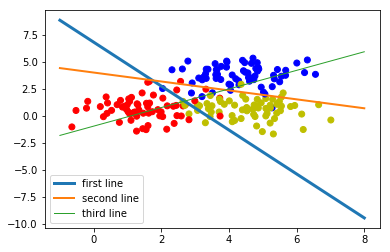

E:\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


[[-2.1863542  0.816832   0.9170777]
 [-1.0766994  1.9783534 -1.0672365]] [ 7.325336  -7.9094257 -1.0183032]


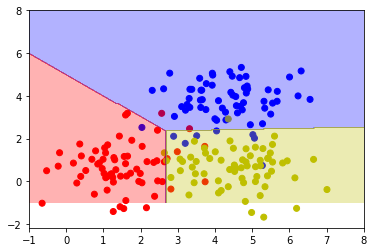

In [17]:
maxEpochs = 50
minibatchSize = 25

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(maxEpochs):
        sumerr = 0
        for i in range(np.int(len(Y)/minibatchSize)):
            x1 = X[i*minibatchSize:(i+1)*minibatchSize,:]
            y1 = Y[i*minibatchSize:(i+1)*minibatchSize,:]
            
            _,lossval,outputval,errval = sess.run([train,loss,output,err],feed_dict={input_features:x1,input_lables:y1})
            sumerr = sumerr + (errval/minibatchSize)
            print('Epoch:','%04d'%(epoch+1),'cost=','{:.9f}'.format(lossval),'err=',sumerr/np.int(len(Y))/minibatchSize)
    train_X, train_Y = generate(200,num_classes,  [[3.0],[3.0,0]],False)
    aa = [np.argmax(l) for l in train_Y]        
    colors =['r' if l == 0 else 'b' if l==1 else 'y' for l in aa[:]]
    plt.scatter(train_X[:,0], train_X[:,1], c=colors)
    
    x = np.linspace(-1,8,200) 

    y=-x*(sess.run(W)[0][0]/sess.run(W)[1][0])-sess.run(b)[0]/sess.run(W)[1][0]
    plt.plot(x,y, label='first line',lw=3)

    y=-x*(sess.run(W)[0][1]/sess.run(W)[1][1])-sess.run(b)[1]/sess.run(W)[1][1]
    plt.plot(x,y, label='second line',lw=2)

    y=-x*(sess.run(W)[0][2]/sess.run(W)[1][2])-sess.run(b)[2]/sess.run(W)[1][2]
    plt.plot(x,y, label='third line',lw=1)
    
    plt.legend()
    plt.show() 
    print(sess.run(W),sess.run(b))
    

    train_X, train_Y = generate(200,num_classes,  [[3.0],[3.0,0]],False)
    aa = [np.argmax(l) for l in train_Y]        
    colors =['r' if l == 0 else 'b' if l==1 else 'y' for l in aa[:]]
    plt.scatter(train_X[:,0], train_X[:,1], c=colors)    
    
    nb_of_xs = 200
    xs1 = np.linspace(-1, 8, num=nb_of_xs)
    xs2 = np.linspace(-1, 8, num=nb_of_xs)
    xx, yy = np.meshgrid(xs1, xs2) # create the grid
    # Initialize and fill the classification plane
    classification_plane = np.zeros((nb_of_xs, nb_of_xs))
    for i in range(nb_of_xs):
        for j in range(nb_of_xs):
            #classification_plane[i,j] = nn_predict(xx[i,j], yy[i,j])
            classification_plane[i,j] = sess.run(a1, feed_dict={input_features: [[ xx[i,j], yy[i,j] ]]} )
    
    
    # Create a color map to show the classification colors of each grid point
    cmap = ListedColormap([
            colorConverter.to_rgba('r', alpha=0.30),
            colorConverter.to_rgba('b', alpha=0.30),
            colorConverter.to_rgba('y', alpha=0.30)])
    # Plot the classification plane with decision boundary and input samples
    plt.contourf(xx, yy, classification_plane, cmap=cmap)
    plt.show()    
            
        

### 3.非线性问题
- 异或问题，简而言之就是用直线分不开的问题。就需要用到多层神经网络来解决了

## （二）使用隐藏层解决非线性问题
### 1.使用带隐藏层的神经网络拟合异或操作

- 构建符合异或规律的数据集作为模拟样本，构建简单的多层神经网络来拟合样本特征完成分类任务

#### （1）数据集介绍
- （0,0）和（1,1）为一类；（0,1），（1,0）为一类

#### （2）网络模型介绍
- 带有一层隐藏层，输入层节点个数：2；隐藏层节点个数：2；输出层节点个数：1

#### （3）定义变量
- 学习率为0.0001，输入占位符为x，输出占位符为y

In [18]:
import tensorflow as tf
import numpy as np
learning_rate = 0.0001
n_input = 2  # 输入层节点个数
n_hidden = 2 # 隐藏层节点个数
n_label = 1  # 输出层节点个数
x = tf.placeholder(tf.float32,[None,n_input])
y = tf.placeholder(tf.float32,[None,n_label])

#### （4）定义学习参数
- 以字典的方式定义w和b，h1表示从输入层到隐藏层，h2表示从隐藏层到输出层

In [19]:
weight = {'h1':tf.Variable(tf.truncated_normal([n_input,n_hidden],stddev=0.1)),
        'h2':tf.Variable(tf.truncated_normal([n_hidden,n_label],stddev=0.1))
        }
biases = {'h1':tf.Variable(tf.zeros([n_hidden])),
          'h2':tf.Variable(tf.zeros([n_label]))
        }

#### （5）定义模型结构
- 模型的输入x经过第一层的w再加上b，通过Relu函数进行激活，生成layer_1的输出
- layer_1的输出经过第二层的w再加上b，使用Tanh激活函数生成最终的输出y_pred

In [20]:
layer_1 = tf.nn.relu(tf.add(tf.matmul(x,weight['h1']),biases['h1']))
y_pred = tf.nn.tanh(tf.add(tf.matmul(layer_1,weight['h2']),biases['h2']))
# 使用MSE loss
loss = tf.reduce_mean((y_pred-y)**2)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

#### （6）构建模拟数据

In [21]:
# 数据生成
X = [[0,0],[0,1],[1,1],[1,0]]
Y = [[0],[1],[0],[1]]
X = np.array(X).astype('float32')
Y = np.array(Y).astype('int16')

#### （7）运行session，生成结果
- 进行10000次迭代，训练模型
- 发现模型效果并不是很好

In [22]:
# 加载Session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        sess.run(train_step,feed_dict={x:X,y:Y})
    print(sess.run(y_pred,feed_dict={x:X}))
    print(sess.run(layer_1,feed_dict={x:X}))

[[0.4996121]
 [0.4996121]
 [0.4996121]
 [0.4996121]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


### 2.非线性网络的意义
- 1.隐藏层神经网络相当于线性可分的高维扩展
    - 线性可分是在一个平面中，通过一条线来分类，如果平面升级到了三维空间，则需要通过一个平面将问题分类
    - 一个隐藏层的作用是将线性可分的问题转化成平面可分的问题
- 2.从逻辑门的角度来理解多层网络

## （三）利用权连接网络将图片进行分类
- 构建一个多层神经网络，从而拟合MNIST样本的特征
### 1.定义网络参数
- 输入输出间使用两个隐藏层，每层256个节点，学习率为0.001

In [23]:
import tensorflow as tf
# 导入 MINST 数据集
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('F:/learnpy/LearnTensorflow/Mnist_clf/MNIST_data/',one_hot=True)

# 定义参数
learning_rate = 0.001
training_epochs = 25
batch_size = 100
display_step = 5

# 设置网络模型参数
n_hidden_1 = 256  # 第一个隐藏节点的个数
n_hidden_2 = 256  # 第二个隐藏节点的个数
n_input = 784     # MNIST共784（28*28）维
n_classes = 10    # MNIST共10类

Extracting F:/learnpy/LearnTensorflow/Mnist_clf/MNIST_data/train-images-idx3-ubyte.gz
Extracting F:/learnpy/LearnTensorflow/Mnist_clf/MNIST_data/train-labels-idx1-ubyte.gz
Extracting F:/learnpy/LearnTensorflow/Mnist_clf/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting F:/learnpy/LearnTensorflow/Mnist_clf/MNIST_data/t10k-labels-idx1-ubyte.gz


### 2.定义网络结构
- 第一层第二层均使用Relu激活函数
- loss使用softmax交叉熵

In [24]:
# 定义占位符
x = tf.placeholder('float',[None,n_input])
y = tf.placeholder('float',[None,n_classes])

# 定义学习参数
weights = {'h1':tf.Variable(tf.random_normal([n_input,n_hidden_1])),
          'h2':tf.Variable(tf.random_normal([n_hidden_1,n_hidden_2])),
          'out':tf.Variable(tf.random_normal([n_hidden_2,n_classes]))
         }
biases = {'b1':tf.Variable(tf.random_normal([n_hidden_1])),
          'b2':tf.Variable(tf.random_normal([n_hidden_2])),
          'out':tf.Variable(tf.random_normal([n_classes]))
         }

# 创建model
def multilayer_perceptron(x,weights,biases):
    # 第一层隐藏层
    layer_1 = tf.add(tf.matmul(x,weights['h1']),biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # 第二层隐藏层
    layer_2 = tf.add((tf.matmul(layer_1,weights['h2'])),biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # 输出层
    out_layer = tf.matmul(layer_2,weights['out']) + biases['out']
    return out_layer

# 构建模型
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# 初始化变量
init = tf.global_variables_initializer()

# 启动session
with tf.Session() as sess:
    sess.run(init)

    # 启动循环开始训练
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # 遍历全部数据集
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # 显示训练中的详细信息
        if epoch % display_step == 0:
            print ("Epoch:", '%04d' % (epoch+1), "cost=","{:.9f}".format(avg_cost))
    print (" Finished!")

#     # 测试 model
#     correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
#     # 计算准确率
#     accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
#     print ("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))


Epoch: 0001 cost= 164.929039237
Epoch: 0006 cost= 8.711151040
Epoch: 0011 cost= 2.032003159
Epoch: 0016 cost= 0.577546704
Epoch: 0021 cost= 0.357716568
 Finished!


## （四）全连接网络中的优化
### 1.异或数据集演示过拟合

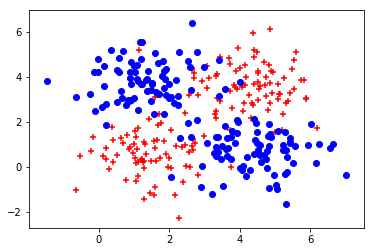

In [25]:
# Ensure we always get the same amount of randomness
np.random.seed(10)

input_dim = 2
num_classes =4 
X, Y = generate(320,num_classes,  [[3.0,0],[3.0,3.0],[0,3.0]],True)
Y=Y%2
#colors = ['r' if l == 0.0 else 'b' for l in Y[:]]
#plt.scatter(X[:,0], X[:,1], c=colors)
xr=[]
xb=[]
for(l,k) in zip(Y[:],X[:]):
    if l == 0.0 :
        xr.append([k[0],k[1]])        
    else:
        xb.append([k[0],k[1]])
xr =np.array(xr)
xb =np.array(xb)      
plt.scatter(xr[:,0], xr[:,1], c='r',marker='+')
plt.scatter(xb[:,0], xb[:,1], c='b',marker='o')

plt.show() 

- 数据可以分为两类，左下和右上是一类（红色加表示），左上和右下是一类（蓝色点表示）

### 2.修改网络定义模型
- 仅仅通过一个隐藏层，通过将隐藏层的节点提升到200就可以将数据划分的很细致，loss值也在逐渐变小


Step: 0 Current loss: 0.72185063
Step: 1000 Current loss: 0.30345526
Step: 2000 Current loss: 0.2131829
Step: 3000 Current loss: 0.19254857
Step: 4000 Current loss: 0.1683051
Step: 5000 Current loss: 0.15602231
Step: 6000 Current loss: 0.15031119
Step: 7000 Current loss: 0.14469679
Step: 8000 Current loss: 0.14162712
Step: 9000 Current loss: 0.13972816
Step: 10000 Current loss: 0.1388954
Step: 11000 Current loss: 0.13658425
Step: 12000 Current loss: 0.13394667
Step: 13000 Current loss: 0.13346721
Step: 14000 Current loss: 0.13321963
Step: 15000 Current loss: 0.1330584
Step: 16000 Current loss: 0.13295695
Step: 17000 Current loss: 0.13290869
Step: 18000 Current loss: 0.13288715
Step: 19000 Current loss: 0.13283153
loss:
 0.13855192


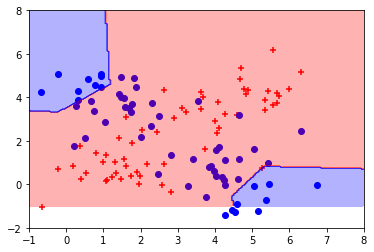

In [33]:
Y=np.reshape(Y,[-1,1])
learning_rate = 1e-4
reg = 0.01
n_input  = 2
n_label  = 1
#n_hidden = 2#欠拟合
n_hidden = 200 


x = tf.placeholder(tf.float32, [None,n_input])
y = tf.placeholder(tf.float32, [None, n_label])

weights = {
    'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden], stddev=0.1)),
    'h2': tf.Variable(tf.random_normal([n_hidden, n_label], stddev=0.1))
    } 
biases = {
    'h1': tf.Variable(tf.zeros([n_hidden])),
    'h2': tf.Variable(tf.zeros([n_label]))
    }    


layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['h1']))
#y_pred = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['h2']),biases['h2']))
#y_pred = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']),biases['h2']))#局部最优解

#y_pred = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['h2']),biases['h2']))

#Leaky relus  40000次 ok
layer2 =tf.add(tf.matmul(layer_1, weights['h2']),biases['h2'])
y_pred = tf.maximum(layer2,0.01*layer2)

# loss=tf.reduce_mean((y_pred-y)**2)
# 带有正则化项
# loss = tf.reduce_mean((y_pred-y)**2 + tf.nn.l2_loss(weights['h1'])*reg + tf.nn.l2_loss(weights['h2'])*reg)
loss = tf.reduce_mean((y_pred-y)**2) + tf.reduce_sum(tf.abs(weights['h1']))*reg + tf.reduce_sum(tf.abs(weights['h2'])*reg)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):#  
        _, loss_val = sess.run([train_step, loss], feed_dict={x: X, y: Y})
        if i % 1000 == 0:
            print ("Step:", i, "Current loss:", loss_val)
    xTrain, yTrain = generate(120,num_classes,  [[3.0,0],[3.0,3.0],[0,3.0]],True)
    yTrain=yTrain%2
#colors = ['r' if l == 0.0 else 'b' for l in yTrain[:]]
#plt.scatter(xTrain[:,0], xTrain[:,1], c=colors)

    xr=[]
    xb=[]
    for(l,k) in zip(yTrain[:],xTrain[:]):
        if l == 0.0 :
            xr.append([k[0],k[1]])        
        else:
            xb.append([k[0],k[1]])
    xr =np.array(xr)
    xb =np.array(xb)      
    plt.scatter(xr[:,0], xr[:,1], c='r',marker='+')
    plt.scatter(xb[:,0], xb[:,1], c='b',marker='o')


    #plt.show() 
    yTrain=np.reshape(yTrain,[-1,1])           
    print ("loss:\n", sess.run(loss, feed_dict={x: xTrain, y: yTrain}))          

    nb_of_xs = 200
    xs1 = np.linspace(-1, 8, num=nb_of_xs)
    xs2 = np.linspace(-1, 8, num=nb_of_xs)
    xx, yy = np.meshgrid(xs1, xs2) # create the grid
    # Initialize and fill the classification plane
    classification_plane = np.zeros((nb_of_xs, nb_of_xs))
    for i in range(nb_of_xs):
        for j in range(nb_of_xs):
            #classification_plane[i,j] = nn_predict(xx[i,j], yy[i,j])
            classification_plane[i,j] = sess.run(y_pred, feed_dict={x: [[ xx[i,j], yy[i,j] ]]} )
            classification_plane[i,j] = int(classification_plane[i,j])

# Create a color map to show the classification colors of each grid point
    cmap = ListedColormap([
            colorConverter.to_rgba('r', alpha=0.30),
            colorConverter.to_rgba('b', alpha=0.30)])
# Plot the classification plane with decision boundary and input samples
    plt.contourf(xx, yy, classification_plane, cmap=cmap)
    plt.show()   

### 3.验证过拟合
- 可以额外生成验证数据集，会发现loss没有原来那么好，说明模型发生了过拟合，真正好的模型需要我们在测试情况下能够表现出跟训练情况下一样的效果。

### 避免过拟合的方法：
- early stopping：理论上可行，但什么时候停止不好把握
- data augmentation：让模型见到更多的情况，最大化的满足全样本，但实际应用中效果不太好
- 正则化（regularization）：增加模型的泛化能力
- dropout：随机在训练中舍去节点

### 4.正则化
- 在损失中再加一项，使得损失值所代表的的输出与标准结果间的误差受到干扰，参数w和b无法按照目标的方向进行调整，模型和训练样本无法完全拟合，从而防止过拟合。正则化实验均在前面代码中。
- loss中增加的干扰项需要有如下特征：
    - 欠拟合时，对模型误差的影响越小越好
    - 过拟合时，对模型误差的影响越大越好
- L1和L2范数
    - L1：所有学习参数w的绝对值的和
    - L2：所有学习参数w的平方和然后求平方根
- tf中的正则化
    - L2正则化函数:tf.nn.l2_loss(t,name=None)
    - L1正则化函数:tf.reduce_sum(tf.abs(w))
    
### 5.Dropout
- 在训练过程中，随机选择一部分节点不去“学习”
- 直觉理解：
    - 让异常数据获得的学习机会变少，因为异常数据在整个数据集合中出现的概率较小，那么忽略节点的学习可以让小概率的异常数据获得的学习机会降低。

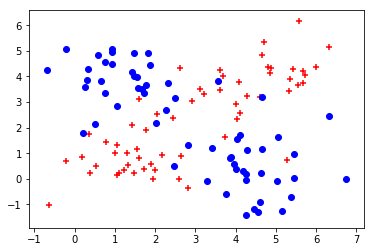

Step: 0 Current loss: 0.44017708
Step: 1000 Current loss: 0.093379825
Step: 2000 Current loss: 0.09245464
Step: 3000 Current loss: 0.09436179
Step: 4000 Current loss: 0.0910229
Step: 5000 Current loss: 0.09127857
Step: 6000 Current loss: 0.09529999
Step: 7000 Current loss: 0.09409856
Step: 8000 Current loss: 0.09357564
Step: 9000 Current loss: 0.09089351
Step: 10000 Current loss: 0.0920721
Step: 11000 Current loss: 0.09240654
Step: 12000 Current loss: 0.09510027
Step: 13000 Current loss: 0.0940078
Step: 14000 Current loss: 0.0903977
Step: 15000 Current loss: 0.09204975
Step: 16000 Current loss: 0.09031579
Step: 17000 Current loss: 0.09133519
Step: 18000 Current loss: 0.090694964
Step: 19000 Current loss: 0.09162919


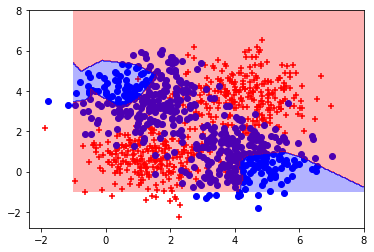

loss:
 0.06029974


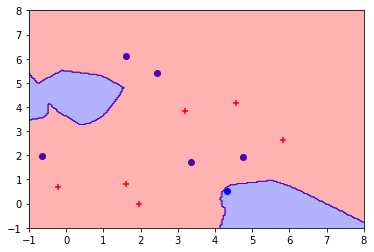

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from matplotlib.colors import colorConverter, ListedColormap 
# 对于上面的fit可以这么扩展变成动态的
from sklearn.preprocessing import OneHotEncoder
def onehot(y,start,end):
    ohe = OneHotEncoder()
    a = np.linspace(start,end-1,end-start)
    b =np.reshape(a,[-1,1]).astype(np.int32)
    ohe.fit(b)
    c=ohe.transform(y).toarray()  
    return c  
    
def generate(sample_size, num_classes, diff,regression=False):
    np.random.seed(10)
    mean = np.random.randn(2)
    cov = np.eye(2)  
    
    #len(diff)
    samples_per_class = int(sample_size/num_classes)

    X0 = np.random.multivariate_normal(mean, cov, samples_per_class)
    Y0 = np.zeros(samples_per_class)
    
    for ci, d in enumerate(diff):
        X1 = np.random.multivariate_normal(mean+d, cov, samples_per_class)
        Y1 = (ci+1)*np.ones(samples_per_class)
    
        X0 = np.concatenate((X0,X1))
        Y0 = np.concatenate((Y0,Y1))

  
    if regression==False: #one-hot  0 into the vector "1 0
        Y0 = np.reshape(Y0,[-1,1])        
        #print(Y0.astype(np.int32))
        Y0 = onehot(Y0.astype(np.int32),0,num_classes)
        #print(Y0)
    X, Y = shuffle(X0, Y0)
    #print(X, Y)
    return X,Y   
    
# Ensure we always get the same amount of randomness
np.random.seed(10)

input_dim = 2
num_classes =4 
X, Y = generate(120,num_classes,  [[3.0,0],[3.0,3.0],[0,3.0]],True)
Y=Y%2
#colors = ['r' if l == 0.0 else 'b' for l in Y[:]]
#plt.scatter(X[:,0], X[:,1], c=colors)
xr=[]
xb=[]
for(l,k) in zip(Y[:],X[:]):
    if l == 0.0 :
        xr.append([k[0],k[1]])        
    else:
        xb.append([k[0],k[1]])
xr =np.array(xr)
xb =np.array(xb)      
plt.scatter(xr[:,0], xr[:,1], c='r',marker='+')
plt.scatter(xb[:,0], xb[:,1], c='b',marker='o')
plt.show() 
Y=np.reshape(Y,[-1,1])

learning_rate = 0.01#1e-4
n_input  = 2
n_label  = 1
n_hidden = 200


x = tf.placeholder(tf.float32, [None,n_input])
y = tf.placeholder(tf.float32, [None, n_label])

weights = {
    'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden], stddev=0.1)),
    'h2': tf.Variable(tf.random_normal([n_hidden, n_label], stddev=0.1))
	} 
biases = {
    'h1': tf.Variable(tf.zeros([n_hidden])),
    'h2': tf.Variable(tf.zeros([n_label]))
    }    


layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['h1']))

keep_prob = tf.placeholder("float")
layer_1_drop = tf.nn.dropout(layer_1, keep_prob)


#Leaky relus
layer2 =tf.add(tf.matmul(layer_1_drop, weights['h2']),biases['h2'])
y_pred = tf.maximum(layer2,0.01*layer2)

reg = 0.01 
#loss=tf.reduce_mean((y_pred-y)**2)+tf.nn.l2_loss(weights['h1'])*reg+tf.nn.l2_loss(weights['h2'])*reg
loss=tf.reduce_mean((y_pred-y)**2)

global_step = tf.Variable(0, trainable=False)
decaylearning_rate = tf.train.exponential_decay(learning_rate, global_step,1000, 0.9)
#train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
train_step = tf.train.AdamOptimizer(decaylearning_rate).minimize(loss,global_step=global_step)

#加载
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
    
for i in range(20000):

    X, Y = generate(1000,num_classes,  [[3.0,0],[3.0,3.0],[0,3.0]],True)
    Y=Y%2
    Y=np.reshape(Y,[-1,1])
  
    _, loss_val = sess.run([train_step, loss], feed_dict={x: X, y: Y,keep_prob:0.6})
   
    if i % 1000 == 0:
        print ("Step:", i, "Current loss:", loss_val)

#colors = ['r' if l == 0.0 else 'b' for l in Y[:]]
#plt.scatter(X[:,0], X[:,1], c=colors)
xr=[]
xb=[]
for(l,k) in zip(Y[:],X[:]):
    if l == 0.0 :
        xr.append([k[0],k[1]])        
    else:
        xb.append([k[0],k[1]])
xr =np.array(xr)
xb =np.array(xb)      
plt.scatter(xr[:,0], xr[:,1], c='r',marker='+')
plt.scatter(xb[:,0], xb[:,1], c='b',marker='o')

    
nb_of_xs = 200
xs1 = np.linspace(-1, 8, num=nb_of_xs)
xs2 = np.linspace(-1, 8, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        #classification_plane[i,j] = nn_predict(xx[i,j], yy[i,j])
        classification_plane[i,j] = sess.run(y_pred, feed_dict={x: [[ xx[i,j], yy[i,j] ]],keep_prob:1.0} )
        classification_plane[i,j] = int(classification_plane[i,j])

# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.30),
        colorConverter.to_rgba('b', alpha=0.30)])
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.show() 


xTrain, yTrain = generate(12,num_classes,  [[3.0,0],[3.0,3.0],[0,3.0]],True)
yTrain=yTrain%2
#colors = ['r' if l == 0.0 else 'b' for l in yTrain[:]]
#plt.scatter(xTrain[:,0], xTrain[:,1], c=colors)


xr=[]
xb=[]
for(l,k) in zip(yTrain[:],xTrain[:]):
    if l == 0.0 :
        xr.append([k[0],k[1]])        
    else:
        xb.append([k[0],k[1]])
xr =np.array(xr)
xb =np.array(xb)      
plt.scatter(xr[:,0], xr[:,1], c='r',marker='+')
plt.scatter(xb[:,0], xb[:,1], c='b',marker='o')


#plt.show() 
yTrain=np.reshape(yTrain,[-1,1])           
print ("loss:\n", sess.run(loss, feed_dict={x: xTrain, y: yTrain,keep_prob:1.0}))          

nb_of_xs = 200
xs1 = np.linspace(-1, 8, num=nb_of_xs)
xs2 = np.linspace(-1, 8, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        #classification_plane[i,j] = nn_predict(xx[i,j], yy[i,j])
        classification_plane[i,j] = sess.run(y_pred, feed_dict={x: [[ xx[i,j], yy[i,j] ]],keep_prob:1.0} )
        classification_plane[i,j] = int(classification_plane[i,j])

# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('r', alpha=0.30),
        colorConverter.to_rgba('b', alpha=0.30)])
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.show()  